In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
TEMPERATURES_CSV = './data/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [8]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        counter = 0
        for row in reader:
            counter+=1
            times.append(counter)
            temperatures.append(float(row[1]))
            
    return times, temperatures

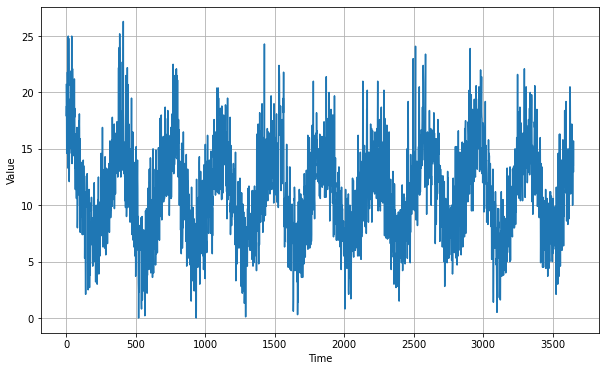

In [9]:
@dataclass
class G:
    TEMPERATURES_CSV = './data/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [10]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [11]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [20]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                          strides=1,
                          activation="relu",
                          padding='causal',
                          input_shape=[64, 1]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
    ])

    return model

In [22]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    
    model.compile(loss='Huber',
                  optimizer='Adam', 
                  metrics=["mae"]) 
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [23]:
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
77/77 [==============================] - 9s 84ms/step - loss: 8.9585 - mae: 9.4551 - lr: 1.0000e-04
Epoch 2/100
77/77 [==============================] - 6s 82ms/step - loss: 5.2479 - mae: 5.7327 - lr: 1.1220e-04
Epoch 3/100
77/77 [==============================] - 6s 83ms/step - loss: 2.9828 - mae: 3.4509 - lr: 1.2589e-04
Epoch 4/100
77/77 [==============================] - 7s 89ms/step - loss: 2.4575 - mae: 2.9163 - lr: 1.4125e-04
Epoch 5/100
77/77 [==============================] - 6s 83ms/step - loss: 1.9729 - mae: 2.4298 - lr: 1.5849e-04
Epoch 6/100
77/77 [==============================] - 6s 80ms/step - loss: 1.8325 - mae: 2.2832 - lr: 1.7783e-04
Epoch 7/100
77/77 [==============================] - 6s 82ms/step - loss: 1.7960 - mae: 2.2449 - lr: 1.9953e-04
Epoch 8/100
77/77 [==============================] - 7s 92ms/step - loss: 1.7587 - mae: 2.2095 - lr: 2.2387e-04
Epoch 9/100
77/77 [==============================] - 8s 109ms/step - loss: 1.7275 - mae: 2.1778 - lr: 2.

(0.0001, 10.0, 0.0, 10.0)

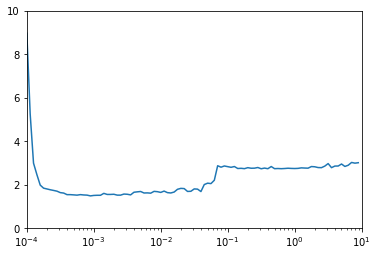

In [24]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

In [28]:
def create_model():

    
    model = create_uncompiled_model()

    model.compile(loss='Huber',
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9),
                  metrics=["mae"])  
    
    return model

In [29]:
model = create_model()

history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 [==============================] - 9s 83ms/step - loss: 9.8835 - mae: 10.3822
Epoch 2/50
77/77 [==============================] - 6s 79ms/step - loss: 8.9041 - mae: 9.4021
Epoch 3/50
77/77 [==============================] - 6s 78ms/step - loss: 6.8224 - mae: 7.3168
Epoch 4/50
77/77 [==============================] - 7s 87ms/step - loss: 3.2903 - mae: 3.7627
Epoch 5/50
77/77 [==============================] - 7s 90ms/step - loss: 2.4030 - mae: 2.8631
Epoch 6/50
77/77 [==============================] - 7s 89ms/step - loss: 2.0797 - mae: 2.5361
Epoch 7/50
77/77 [==============================] - 7s 91ms/step - loss: 1.8579 - mae: 2.3098
Epoch 8/50
77/77 [==============================] - 7s 86ms/step - loss: 1.8635 - mae: 2.3156
Epoch 9/50
77/77 [==============================] - 7s 87ms/step - loss: 1.8217 - mae: 2.2726
Epoch 10/50
77/77 [==============================] - 7s 85ms/step - loss: 1.7925 - mae: 2.2422
Epoch 11/50
77/77 [==============================] - 7s 86

In [30]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [31]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

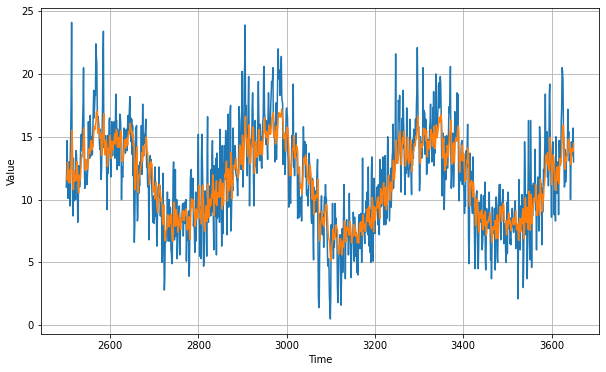

In [32]:
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [33]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.78, mae: 1.86 for forecast
